In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [7]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Climate Analysis

C:\Users\jacob\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


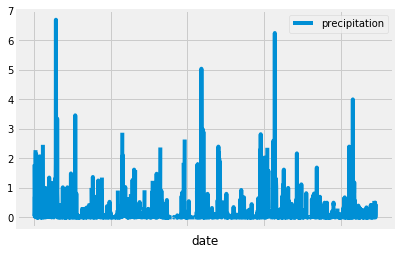

In [129]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)


![precipitation](Images/precipitation.png)

In [130]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
mostActiveStationQuery = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station)).all()
mostActiveStationQuery

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostActiveStation = mostActiveStationQuery[len(mostActiveStationQuery)-1].station

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == mostActiveStation).all()



[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

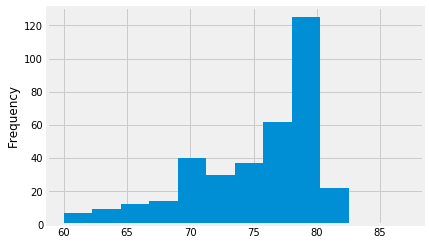

In [127]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


stationsWithObs = session.query(Measurement.station, func.sum(Measurement.tobs)).group_by(Measurement.station).order_by(func.sum(Measurement.tobs)).all()

highestStation = stationsWithObs[len(stationsWithObs)-1][0]

measurements = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == highestStation).filter(Measurement.date > prev_year).order_by(Measurement.date).all()
measurements

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(measurements)

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(df['tobs'], 12)

plt.ylabel("Frequency")


![precipitation](Images/station-histogram.png)

In [71]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [105]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startDate = '2017-06-01'
endDate = '2017-06-05'
tempResults = calc_temps(startDate, endDate)
tempResults

[(74.0, 77.90322580645162, 81.0)]

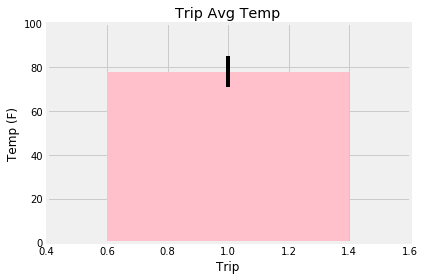

In [115]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = tempResults[0][2]-tempResults[0][0]
avgtemp = tempResults[0][1]


fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'pink', yerr=error)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")
plt.ylim(0, 100)
plt.xlim(.4, 1.6)
fig.tight_layout()
plt.show()

